# **Image Data Augmentation**

In this notebook, we explore various **image augmentation techniques** for CIFAR-10 classification. Augmentation can help reduce overfitting by synthesizing additional training examples. We’ll:
- Implement multiple augmentation pipelines (random flips, rotation, cropping, color jitter, etc.).  
- Train a simple CNN on each pipeline.  
- Compare final accuracies, class-wise performance, and robustness to specific image corruptions.

You’ll see how certain augmentations can significantly improve generalization or help the model handle noisy test conditions.


---

##📚 **Library Overview**

- **PyTorch** ([Docs](https://pytorch.org/docs/stable/)):  
  - **`nn`**: Building neural networks.  
  - **`optim`**: Optimization algorithms.  
  - **`transforms`**: Common image transformations and data augmentation.  
- **Torchvision** ([Docs](https://pytorch.org/vision/stable/)):  
  - **`datasets`**: CIFAR-10, among others.  
  - **`utils`**: For grid displays of images (`make_grid`).  
- **Matplotlib** ([Docs](https://matplotlib.org/)):  
  - Plot training curves, bar charts, sample images.
- **Numpy**, **time**, **copy**: Utilities for numeric calculations, measuring training times, duplicating objects, etc.


## **Imports, Random Seed, and GPU Availability**


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Function to check if GPU is available
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("GPU not available, using CPU instead")
    return device


**Explanation:**

- **PyTorch** modules (`torch`, `nn`, `optim`, etc.) for model building and optimization.
- **Torchvision** components for datasets (`CIFAR10`) and transforms (`transforms`, `make_grid`).
- **Matplotlib** and **numpy** for plotting and numerical operations.
- **`copy`, `PIL.Image`, `time`**: Utilities for deep copying objects, image handling, and measuring execution time.
- We **fix random seeds** (`torch.manual_seed(42)` and `np.random.seed(42)`) to improve reproducibility.
- **`get_device()`** checks if **CUDA** is available, prints GPU info if so, otherwise defaults to CPU.


## **Simple CNN**


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

        # Activation and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # First conv block
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        # Second conv block
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten for fully connected layer
        x = x.view(-1, 64 * 8 * 8)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


**Explanation:**

- **`conv1`** / **`conv2`**: Two convolutional layers with 32 and 64 filters.  
- **`pool`**: Uses 2×2 max pooling to reduce spatial dimensions by half.  
- **`fc1`**: Fully connected layer (64×8×8 → 256).  
- **`fc2`**: Outputs 10 classes (CIFAR-10).  
- **`dropout`**: Reduces overfitting by randomly “dropping” 25% of neurons during training.


## **AugmentationExperiment**


In [3]:
class AugmentationExperiment:
    def __init__(self, name, transform):
        self.name = name
        self.transform = transform

    def load_data(self, batch_size=128):
        # Load training dataset with specified transform
        trainset = torchvision.datasets.CIFAR10(
            root='./data',
            train=True,
            download=True,
            transform=self.transform
        )
        trainloader = torch.utils.data.DataLoader(
            trainset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2
        )

        # Test dataset with a basic (no augmentation) transform
        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        testset = torchvision.datasets.CIFAR10(
            root='./data',
            train=False,
            download=True,
            transform=test_transform
        )
        testloader = torch.utils.data.DataLoader(
            testset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2
        )

        classes = ('plane', 'car', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck')

        return trainloader, testloader, classes


**Explanation:**

- This class holds:
  - A **name** (e.g., “Random Rotation”, “Color Jitter”)  
  - A **transform**: The augmentation pipeline (random flips, rotations, etc.).
- **`load_data(...)`**:
  - Applies the **augmentation transform** for the training set.
  - Applies a **basic normalization** for the test set (no augmentation).
  - Returns **trainloader**, **testloader**, and class labels.


## **Creating Multiple Data Augmentation Pipelines**


In [4]:
def create_augmentation_experiments():
    # 1. No augmentation (baseline)
    no_aug = AugmentationExperiment(
        "No Augmentation (Baseline)",
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    )

    # 2. Horizontal Flip
    h_flip = AugmentationExperiment(
        "Horizontal Flip",
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    )

    # 3. Random Rotation
    rotation = AugmentationExperiment(
        "Random Rotation",
        transforms.Compose([
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    )

    # 4. Random Crop
    crop = AugmentationExperiment(
        "Random Crop",
        transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    )

    # 5. Color Jitter
    color_jitter = AugmentationExperiment(
        "Color Jitter",
        transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    )

    # 6. Gaussian Blur
    blur = AugmentationExperiment(
        "Gaussian Blur",
        transforms.Compose([
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    )

    # 7. Perspective Transform
    perspective = AugmentationExperiment(
        "Perspective Transform",
        transforms.Compose([
            transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    )

    # 8. Extensive Augmentation (combining multiple)
    extensive = AugmentationExperiment(
        "Extensive Augmentation",
        transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    )

    return [no_aug, h_flip, rotation, crop, color_jitter, blur, perspective, extensive]


**Explanation:**

1. **No Augmentation (Baseline)**: Just normalization.  
2. **Horizontal Flip**: 50% chance of flipping the image horizontally.  
3. **Random Rotation**: Up to ±15 degrees.  
4. **Random Crop**: Crops a 32×32 region with 4 pixels of padding.  
5. **Color Jitter**: Randomly changes brightness, contrast, saturation.  
6. **Gaussian Blur**: Blurs image with a 3×3 kernel and a random sigma.  
7. **Perspective Transform**: Warps image with a specified distortion scale.  
8. **Extensive Augmentation**: Combines multiple transformations (crop, flip, color jitter, rotation).


## **Visualizing Augmentations**


In [5]:
def visualize_augmentations(experiments):
    # Load a single batch from CIFAR-10
    dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

    # Select a few images
    num_images = 4
    image_indices = np.random.choice(len(dataset), num_images, replace=False)

    fig, axes = plt.subplots(len(experiments), num_images, figsize=(12, 20))
    fig.suptitle("Effect of Different Augmentation Techniques", fontsize=16)

    for i, experiment in enumerate(experiments):
        axes[i, 0].set_ylabel(experiment.name, rotation=90, fontsize=10)

        for j, idx in enumerate(image_indices):
            img, _ = dataset[idx]
            img = experiment.transform(img)

            # Convert tensor to numpy array for displaying
            if isinstance(img, torch.Tensor):
                img = img.numpy().transpose((1, 2, 0))
                img = img * 0.5 + 0.5  # denormalize
                img = np.clip(img, 0, 1)

            axes[i, j].imshow(img)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()


**Explanation:**

- **`visualize_augmentations`**:
  1. Downloads **CIFAR-10** (train split) in untransformed form.  
  2. Randomly selects **4** images from the dataset.
  3. Applies each **augmentation experiment**’s transform to the same images.
  4. Displays how each transformation modifies the original images.


## **Model Training**


In [6]:
def train_model(model, trainloader, device, epochs=5, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {
        'train_loss': [],
        'train_acc': []
    }

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Epoch-level metrics
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100.0 * correct / total

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2f}%")

    time_elapsed = time.time() - start_time
    print(f"Training complete in {time_elapsed:.2f} seconds")

    return model, history


**Explanation:**

- Trains **`model`** on the **`trainloader`** for **`epochs`**:
  - Uses **CrossEntropyLoss** and **Adam** with a default **learning_rate=0.001**.
  - Accumulates **train loss** and **train accuracy** each epoch in a **history** dictionary.
  - Prints out performance after each epoch, indicating progress.


## **Evaluation Function**


In [7]:
def evaluate_model(model, testloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


**Explanation:**

- Sets **`model.eval()`** to disable dropout/batchnorm updates.
- Loops through **`testloader`** without computing gradients:
  - Gets predictions via **`torch.max`**.
  - Calculates overall accuracy = \(\frac{\text{correct}}{\text{total}} \times 100\%\).


## **Run Experiments**


In [8]:
def run_experiments(experiments, device, epochs=5):
    results = {}
    histories = {}

    for experiment in experiments:
        print(f"\n{'='*50}")
        print(f"Running experiment: {experiment.name}")
        print(f"{'='*50}")

        # Load data with the specific augmentation
        trainloader, testloader, _ = experiment.load_data()

        # Initialize a new model
        model = SimpleCNN().to(device)

        # Train the model
        trained_model, history = train_model(model, trainloader, device, epochs=epochs)

        # Evaluate the model
        accuracy = evaluate_model(trained_model, testloader, device)

        # Store results
        results[experiment.name] = accuracy
        histories[experiment.name] = history

    return results, histories


**Explanation:**

- Iterates over each **augmentation experiment**:
  1. **`load_data`** to get the train/test loaders with the chosen augmentations.
  2. Creates a fresh **`SimpleCNN()`** model on the current **`device`**.
  3. **Trains** the model for a specified number of epochs (default 5).
  4. **Evaluates** on the test set.
  5. Saves **accuracy** in a results dict and the entire training **history** for later plots.


## **Plotting Overall Results**


In [9]:
def plot_results(results, histories):
    # Plot the final accuracy comparison
    plt.figure(figsize=(12, 6))
    plt.bar(results.keys(), results.values())
    plt.title('Test Accuracy by Augmentation Strategy')
    plt.xlabel('Augmentation Strategy')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Add accuracy values on top
    for i, (key, value) in enumerate(results.items()):
        plt.text(i, value + 0.5, f"{value:.2f}%", ha='center')

    plt.show()

    # Plot training histories
    plt.figure(figsize=(15, 10))

    # Training loss
    plt.subplot(2, 1, 1)
    for name, history in histories.items():
        plt.plot(history['train_loss'], label=name)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Training accuracy
    plt.subplot(2, 1, 2)
    for name, history in histories.items():
        plt.plot(history['train_acc'], label=name)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


**Explanation:**

1. **Bar Chart**: Shows final **test accuracy** for each augmentation experiment side by side.
2. **Training Curves** (loss & accuracy):
   - Compares each augmentation strategy’s training performance over epochs.
   - Helps visualize how quickly or effectively each augmentation converges.


## **Analyzing Class-Wise Performance**


In [10]:
def analyze_class_performance(experiments, device, classes):
    # We'll pick a few interesting strategies to compare in detail
    selected_experiments = [
        experiments[0],  # No Augmentation (Baseline)
        experiments[1],  # Horizontal flip
        experiments[7]   # Extensive Augmentation
    ]

    class_accuracies = {}

    for experiment in selected_experiments:
        print(f"\nAnalyzing class performance for: {experiment.name}")

        trainloader, testloader, _ = experiment.load_data()

        # Train a new model
        model = SimpleCNN().to(device)
        model, _ = train_model(model, trainloader, device, epochs=5)

        # Evaluate per class
        model.eval()
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                c = (predicted == labels).squeeze()
                for i in range(labels.size(0)):
                    label = labels[i].item()
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        # Print and store class accuracies
        class_acc = {}
        for i in range(10):
            accuracy = 100 * class_correct[i] / class_total[i]
            class_acc[classes[i]] = accuracy
            print(f'Accuracy of {classes[i]}: {accuracy:.2f}%')
        class_accuracies[experiment.name] = class_acc

    # Plot class-wise comparisons
    plt.figure(figsize=(15, 8))
    bar_width = 0.25
    index = np.arange(len(classes))

    for i, (name, accuracies) in enumerate(class_accuracies.items()):
        plt.bar(index + i*bar_width,
                [accuracies[cls] for cls in classes],
                bar_width,
                label=name)

    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Class-wise Accuracy Comparison')
    plt.xticks(index + bar_width, classes)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return class_accuracies


**Explanation:**

- Chooses 3 experiments for a more detailed breakdown:
  1. **No Augmentation (Baseline)**  
  2. **Horizontal Flip**  
  3. **Extensive Augmentation**
- Trains and tests each one, collecting **class_correct** and **class_total**.
- Plots a grouped bar chart comparing the per-class accuracy across these augmentations.


## **Robustness to Image Corruptions**


In [11]:
def test_robustness(experiment, device, classes):
    print(f"\nTesting robustness of model trained with: {experiment.name}")

    # Load data and train model
    trainloader, _, _ = experiment.load_data()
    model = SimpleCNN().to(device)
    model, _ = train_model(model, trainloader, device, epochs=5)

    # Define corruption transforms to test robustness
    corruptions = {
        "Gaussian Noise": transforms.Compose([
            transforms.ToTensor(),
            lambda x: x + 0.1 * torch.randn_like(x),
            lambda x: torch.clamp(x, 0, 1),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        "Brightness Shift": transforms.Compose([
            transforms.ToTensor(),
            lambda x: torch.clamp(x + 0.1, 0, 1),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        "Contrast Reduction": transforms.Compose([
            transforms.ToTensor(),
            lambda x: torch.clamp(0.8 * x + 0.1, 0, 1),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    }

    results = {}

    for name, transform in corruptions.items():
        # Create corrupted test dataset
        testset = torchvision.datasets.CIFAR10(
            root='./data',
            train=False,
            download=True,
            transform=transform
        )
        testloader = torch.utils.data.DataLoader(
            testset,
            batch_size=128,
            shuffle=False,
            num_workers=2
        )

        # Evaluate
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100.0 * correct / total
        results[name] = accuracy
        print(f"Accuracy under {name}: {accuracy:.2f}%")

    return results


**Explanation:**

- **`test_robustness(experiment, device, classes)`**:
  1. Trains a model on the given augmentation strategy.  
  2. Defines a dictionary of **corruptions** (e.g., Gaussian noise, brightness shift, contrast reduction).  
  3. Creates a custom transform for each corruption scenario and **evaluates** how the model performs on this corrupted version of the test set.
- Returns a dictionary of corruption type to accuracy percentage.


## **Main Execution**


Using GPU: Tesla T4


100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Visualizing augmentation techniques...
Files already downloaded and verified


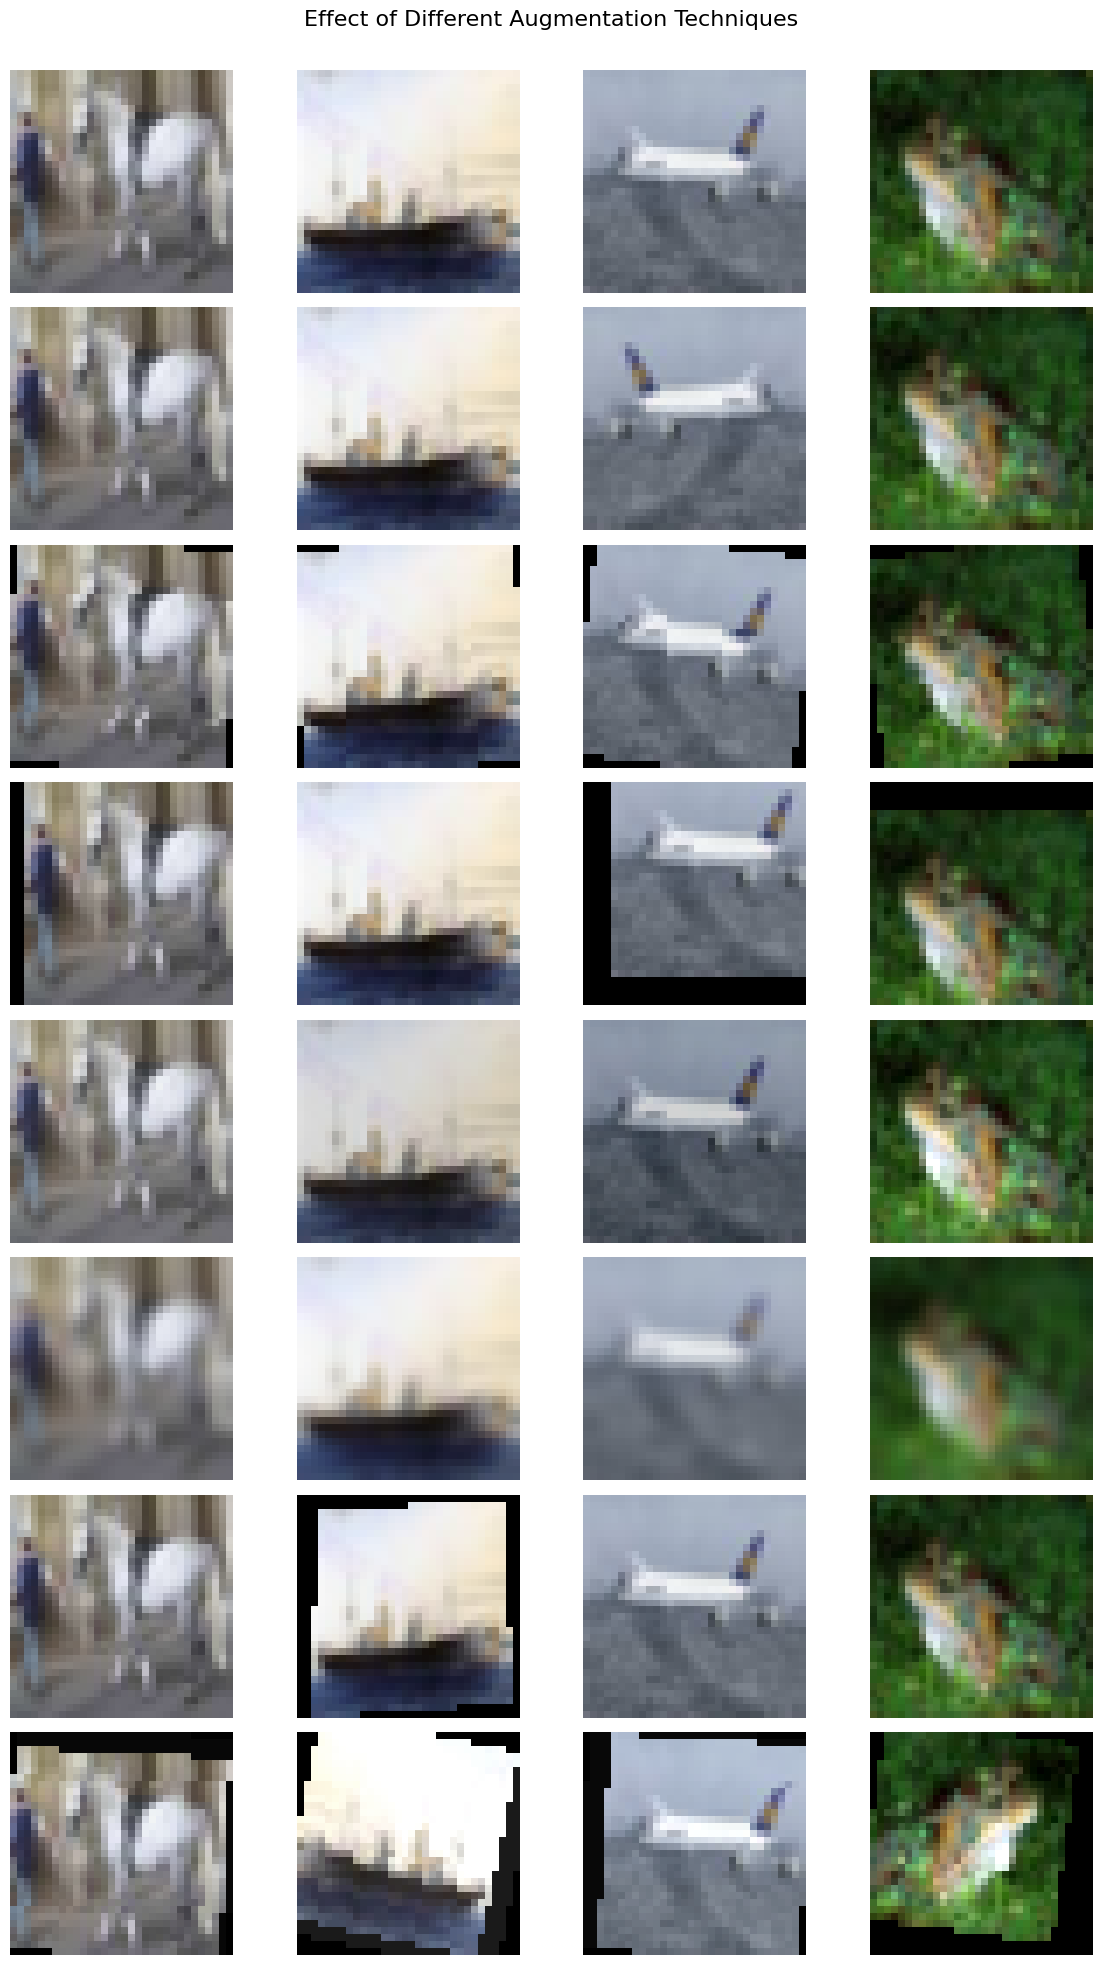


Running experiments with different augmentation strategies...

Running experiment: No Augmentation (Baseline)
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5 - Loss: 1.4492 - Accuracy: 47.87%
Epoch 2/5 - Loss: 1.0738 - Accuracy: 61.66%
Epoch 3/5 - Loss: 0.9223 - Accuracy: 67.01%
Epoch 4/5 - Loss: 0.8092 - Accuracy: 71.54%
Epoch 5/5 - Loss: 0.7202 - Accuracy: 74.57%
Training complete in 65.39 seconds
Test Accuracy: 71.59%

Running experiment: Horizontal Flip
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5 - Loss: 1.4154 - Accuracy: 49.21%
Epoch 2/5 - Loss: 1.0584 - Accuracy: 62.29%
Epoch 3/5 - Loss: 0.9187 - Accuracy: 67.61%
Epoch 4/5 - Loss: 0.8260 - Accuracy: 70.94%
Epoch 5/5 - Loss: 0.7605 - Accuracy: 73.28%
Training complete in 75.08 seconds
Test Accuracy: 72.32%

Running experiment: Random Rotation
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5 - Loss: 1.4816 - Accura

In [ ]:
def main():
    # Set up device
    device = get_device()

    # Create augmentation experiments
    experiments = create_augmentation_experiments()

    # Get class names (from baseline)
    _, _, classes = experiments[0].load_data()

    # Visualize the different augmentations
    print("Visualizing augmentation techniques...")
    visualize_augmentations(experiments)

    # Run experiments with different augmentation strategies
    print("\nRunning experiments with different augmentation strategies...")
    results, histories = run_experiments(experiments, device, epochs=5)

    # Plot results
    print("\nPlotting results...")
    plot_results(results, histories)

    # Analyze class-wise performance
    print("\nAnalyzing class-wise performance...")
    class_performance = analyze_class_performance(experiments, device, classes)

    # Test robustness on the "Extensive Augmentation" model
    print("\nTesting model robustness...")
    robustness_results = test_robustness(experiments[7], device, classes)

    # Compare with baseline model robustness
    baseline_robustness = test_robustness(experiments[0], device, classes)

    # Plot robustness comparison
    plt.figure(figsize=(10, 6))
    corruptions = list(robustness_results.keys())
    x = np.arange(len(corruptions))
    width = 0.35

    plt.bar(x - width/2, [baseline_robustness[c] for c in corruptions], width, label='No Augmentation')
    plt.bar(x + width/2, [robustness_results[c] for c in corruptions], width, label='Extensive Augmentation')
    plt.ylabel('Accuracy (%)')
    plt.title('Robustness to Image Corruptions')
    plt.xticks(x, corruptions)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Final conclusions
    print("\n=== Final Conclusions ===")
    best_aug = max(results, key=results.get)
    print(f"Best augmentation strategy: {best_aug} with {results[best_aug]:.2f}% accuracy")
    baseline_acc = results['No Augmentation (Baseline)']
    improvement = results[best_aug] - baseline_acc
    print(f"Improvement over baseline: {improvement:.2f}%")

    # Check which classes benefited most
    if best_aug in class_performance and 'No Augmentation (Baseline)' in class_performance:
        best_class_acc = class_performance[best_aug]
        base_class_acc = class_performance['No Augmentation (Baseline)']
        improvements = {
            cls: best_class_acc[cls] - base_class_acc[cls] for cls in classes
        }
        most_improved = max(improvements, key=improvements.get)
        print(f"Class that benefited most: {most_improved} with {improvements[most_improved]:.2f}% improvement")

if __name__ == "__main__":
    main()


**Explanation:**

1. **`get_device()`**: GPU or CPU selection.  
2. **`create_augmentation_experiments()`**: Returns 8 different augmentations.  
3. **`load_data`** for classes from the baseline experiment.  
4. **`visualize_augmentations`**: Demonstrates how each transform modifies sample images.  
5. **`run_experiments`**: Trains each augmentation strategy for 5 epochs, collects final test accuracy.  
6. **`plot_results`**: Creates a bar chart of final accuracies and line plots for training histories.  
7. **`analyze_class_performance`**: Detailed breakdown for 3 selected strategies (baseline, horizontal flip, extensive).  
8. **`test_robustness`**: Evaluates how well the baseline vs. extensively augmented model handle different corruptions (Gaussian noise, brightness shift, contrast changes).  
9. Prints final conclusions:  
   - Which augmentation gave the **best** overall accuracy.  
   - How much **improvement** over baseline.  
   - Which **class** saw the biggest accuracy gain from that augmentation.


## 📚 **Additional Reading & References**

- **PyTorch Tutorials**:  
  - [Data Augmentation with Transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

- **fast.ai** Course:  
  - [Practical Deep Learning for Coders](https://course.fast.ai/) – This course shows best practices for data augmentation and advanced CNNs.

- **Kaggle**:  
  - [CIFAR-10 Data Augmentation Kernels](https://www.kaggle.com/search?q=cifar+10+data+augmentation) – Explore kernels that demonstrate extensive data augmentation on CIFAR-10 or similar datasets.

- **Research**:  
  - [AutoAugment (Google Brain)](https://arxiv.org/abs/1805.09501) – Automated search for augmentation policies.  
  - [RandAugment](https://arxiv.org/abs/1909.13719) – A simplified and robust augmentation strategy.
